<a href="https://colab.research.google.com/github/DangLeUyen/Computer-Vision-From-Scratch/blob/main/flowers_classification_AlexNet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 flowers classification using AlexNet.

The following code is based on the book **Practical Machine Learning for Computer Vision** by Valliappa Lakshmanan, Martin Gorner, and Ryan Gillard.

- *Convolutional Network*: works by sliding a small window (convolutional filter) across the image to extract spatial features.
- *Convolutional Filter*:
  - **\# of Learnable weights = filter_width * filter_height * \# of channels**
  - For example: $4 \times 4$ filter for color images will have 4 * 4 * 3 = 48 learnable weights in total.
- *Convolutional layer*: contains tens of hundreds of similar filters, each with its own independent learable parameters -> output is a multichannel set of 2D values.
  
  $W[4, 4, 3, 5]$ means filter size is (4, 4), \# of channels is 3, and \# of filters is 5
  -> Output: Conv 4,4,5

  The total learnable parameters: 4 * 4 * 3 * 5=240.
- *Pooling layer*: reduces spatial size and computation. Max Pooling (only the maximum value is retained for each group) is the most common type. Others are Average Pooling, Global Pooling. Benefits of pooling:
  - Downsamples feature maps.
  - Introduces spatial invariance.
  - Reduces parameters.
- *Stride*: the number of pixels the filter moves at each step when sliding across the image. stride = 2 means the filter shifts 2 pixels at a time horizontally (and vertically).
- *Padding*: how the input borders are handled when applying a convolution. If padding is 'valid', no padding is added. If padding is 'same', zero-padding is added so the output has the same height and width as the input (for stride = 1).

**Note: Inputs and Outputs of convolutional layers are 4D tensors [batch_size, height, width, channels]**

Example: a batch of 16 color (RGB) images of $256 \times 256$ pixels is a tensor [16, 256, 256, 3]

- *Activation*: a function applied to the weighted sum of the inputs to a node, making neuron network nonlinear. Common activation functions include Sigmoid, ReLU, leakyReLU.
  - $\text{Sigmoid}(x) = \frac{1}{1 + e^{-x}}$
  - $\text{ReLU} = \max(0, x)$
  - $\text{LeakyReLU} = \max(0.1x, x)$
- *Softmax*: a special activation function used as the last step in multiclass classifiers. It normalizes the vector to have a sum of 1 so that it can be interpreted as a vector of probabilities.
- *Dropout*: randomly "drop" (i.e set to zero) a fraction of neurons in a layer at each forward pass. Dropout is only applied during training.
- *Batch Normalization*: normalizes activations in intermediate layes to zero mean and unit variance (mean = 0, variance = 1).
- *Early Stopping*: stops training when the model starts to overfit.
- *Epoch*: a full pass through the training dataset during training.

## AlexNet (2012) by Alex Krizhevsky et al.
is a mix of convolutional layers and max-pooling layers.

The AlexNet architecture:

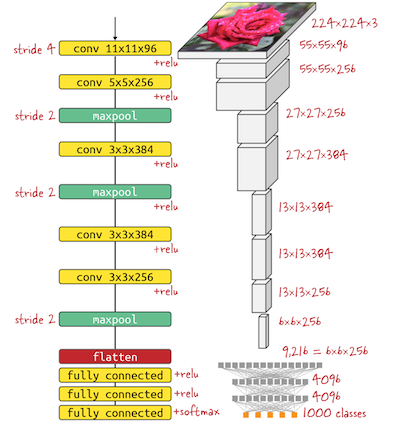

### Import necessary libraries

In [ ]:
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import pathlib
from PIL import Image
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


### AlexNet class from scratch

In [ ]:
class Alexnet(nn.Module):
  def __init__(self, num_classes=1000, dropout=0.5) -> None:
      super().__init__()
      self.convlayers =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
      self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
      self.classifierlayers = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
      )

  def forward(self, x) -> torch.Tensor:
      x = self.convlayers(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.classifierlayers(x)
      return x



In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):

    res = {
        'train_accuracy': [],
        'val_accuracy': [],
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        running_loss = 0.0

        print(f"\nEpoch {epoch + 1}/{epochs}")

        # -------- TRAINING --------
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            batch_correct = (preds == labels).sum().item()
            train_correct += batch_correct
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        train_loss = running_loss / len(train_loader)

        print(f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_acc:.4f}")

        # -------- VALIDATION --------
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss = val_running_loss / len(val_loader)

        print(f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_acc:.4f}")

        # -------- SAVE METRICS --------
        res['train_accuracy'].append(train_acc)
        res['val_accuracy'].append(val_acc)
        res['train_loss'].append(train_loss)
        res['val_loss'].append(val_loss)

    return res


def plot_metrics(res):

    epochs = range(1, len(res['train_accuracy']) + 1)

    # ----- LOSS CURVE -----
    plt.figure()
    plt.plot(epochs, res['train_loss'], label='Training Loss')
    plt.plot(epochs, res['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # ----- ACCURACY CURVE -----
    plt.figure()
    plt.plot(epochs, res['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, res['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


### Load datasets

In [ ]:
import tarfile
import urllib.request

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
tar_path = "./flower_photos.tgz"

urllib.request.urlretrieve(dataset_url, tar_path)

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path="./")  # extracts to ./flower_photos

/tmp/ipython-input-300307970.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="./")  # extracts to ./flower_photos


In [ ]:
data_dir = pathlib.Path('flower_photos')
list(data_dir.glob('*/*.jpg'))[:5]


[PosixPath('flower_photos/roses/15761264350_4caaf080f6_m.jpg'),
 PosixPath('flower_photos/roses/2863863372_605e29c03e_m.jpg'),
 PosixPath('flower_photos/roses/22506717337_0fd63e53e9.jpg'),
 PosixPath('flower_photos/roses/14943194730_f48b4d4547_n.jpg'),
 PosixPath('flower_photos/roses/16018886851_c32746cb72.jpg')]

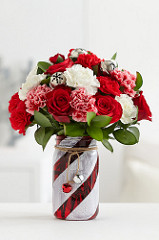

In [ ]:
roses = list(data_dir.glob('roses/*'))
Image.open(str(roses[0]))


In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 15

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder("flower_photos")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split dataset into training set and validation set
train_subset, val_subset = random_split(dataset, [train_size, val_size])

train_dataset = torch.utils.data.Subset(
    datasets.ImageFolder("flower_photos", transform=transform),
    train_subset.indices
)

val_dataset = torch.utils.data.Subset(
    datasets.ImageFolder("flower_photos", transform=transform),
    val_subset.indices
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
num_classes = len(dataset.classes)

In [ ]:
# Alexnet Model
model = Alexnet(num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
res = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=NUM_EPOCHS)


Epoch 1/15
Train Loss: 1.4491, Train Accuracy: 0.3168
Validation Loss: 1.2234, Validation Accuracy: 0.4741

Epoch 2/15
Train Loss: 1.1859, Train Accuracy: 0.4619
Validation Loss: 1.0950, Validation Accuracy: 0.5123

Epoch 3/15
Train Loss: 1.0873, Train Accuracy: 0.5266
Validation Loss: 1.0887, Validation Accuracy: 0.5136

Epoch 4/15
Train Loss: 0.9634, Train Accuracy: 0.6107
Validation Loss: 0.9776, Validation Accuracy: 0.5736

Epoch 5/15
Train Loss: 0.8892, Train Accuracy: 0.6529
Validation Loss: 0.8756, Validation Accuracy: 0.6499

Epoch 6/15
Train Loss: 0.8169, Train Accuracy: 0.6778
Validation Loss: 0.8150, Validation Accuracy: 0.6921

Epoch 7/15
Train Loss: 0.7419, Train Accuracy: 0.7153
Validation Loss: 0.8005, Validation Accuracy: 0.6962

Epoch 8/15
Train Loss: 0.7006, Train Accuracy: 0.7323
Validation Loss: 0.7541, Validation Accuracy: 0.7044

Epoch 9/15
Train Loss: 0.6087, Train Accuracy: 0.7681
Validation Loss: 0.7326, Validation Accuracy: 0.7139

Epoch 10/15
Train Loss: 0.5

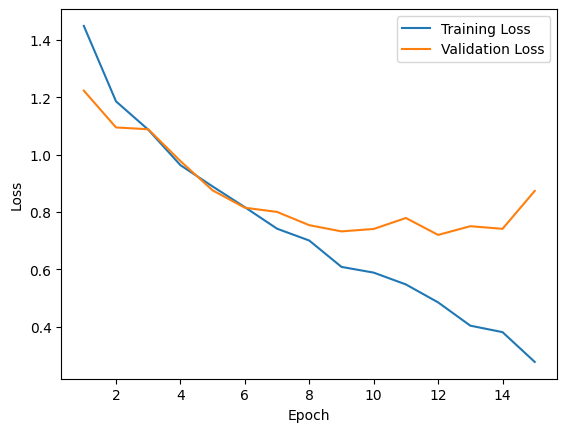

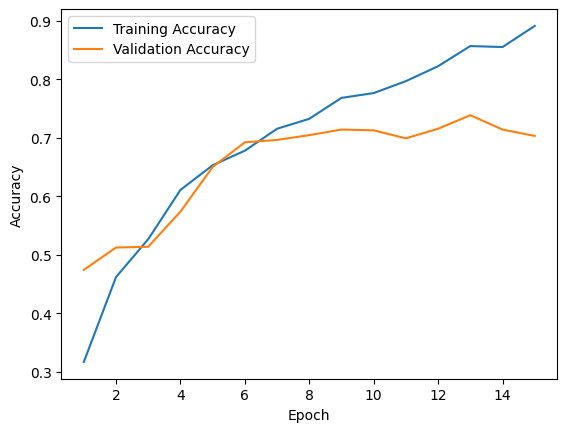

In [ ]:
# Plot results
plot_metrics(res)